In [85]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# GLOBAL CONFIG
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/X1_all_rank_features_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/X2_all_rank_features_with_y.tsv"

OUTPUT_DIR = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/all_features"  # 🟩 請確認這個資料夾存在
os.makedirs(f"{OUTPUT_DIR}/binary", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/regression", exist_ok=True)

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_RANK = "gex_rank"
TARGET_BINARY = "gex_binary"

chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

# ============================================================
# LOAD DATA
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

# Binary labels
df_train_full[TARGET_BINARY] = (df_train_full["gex"] > 0.0).astype(int)
df_val_full[TARGET_BINARY]   = (df_val_full["gex"] > 0.0).astype(int)

feature_cols = [c for c in df_train_full.columns if c not in META_COLS + [TARGET_BINARY]]
print(f"Feature count: {len(feature_cols)}")

# ============================================================
# MODEL CONFIGS
# ============================================================

params_bin = {
    "objective": "binary",
    "metric": ["auc"],
    "learning_rate": 0.016676974956976915,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.64561553423692,
    "bagging_fraction": 0.8113835038425429,
    "bagging_freq": 6,
    "lambda_l1": 0.3316673054635859,
    "lambda_l2": 0.8969317795206216,
    "min_gain_to_split": 0.04923442843722911,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}

params_reg = params_bin.copy()
params_reg.update({
    "objective": "regression",
    "metric": "rmse"
})

# ============================================================
# STORAGE
# ============================================================
results = []
shap_binary_folds = []
shap_reg_folds = []

# ============================================================
# CROSS-CHROMOSOME TRAINING
# ============================================================
for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🚀 Fold {fold_idx+1} | Validation chromosomes: {val_chrs}")

    # Split by chromosome
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    X_train, y_train_bin, y_train_reg = (
        df_train[feature_cols],
        df_train[TARGET_BINARY],
        df_train[TARGET_RANK],
    )
    X_val, y_val_bin, y_val_reg = (
        df_val[feature_cols],
        df_val[TARGET_BINARY],
        df_val[TARGET_RANK],
    )

    # =======================================================
    # 🧠 Binary Classifier
    # =======================================================
    dtrain_bin = lgb.Dataset(X_train, label=y_train_bin)
    dval_bin   = lgb.Dataset(X_val, label=y_val_bin, reference=dtrain_bin)

    model_bin = lgb.train(
        params_bin,
        dtrain_bin,
        valid_sets=[dtrain_bin, dval_bin],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val["pred_prob"] = model_bin.predict(X_val, num_iteration=model_bin.best_iteration)

    auc = roc_auc_score(y_val_bin, df_val["pred_prob"])
    acc = accuracy_score(y_val_bin, (df_val["pred_prob"] >= 0.5))
    f1  = f1_score(y_val_bin, (df_val["pred_prob"] >= 0.5))
    print(f"📈 Binary Classifier: AUC={auc:.4f}, ACC={acc:.4f}, F1={f1:.4f}")

    # ---- SHAP for binary
    explainer_bin = shap.TreeExplainer(model_bin)
    shap_values_bin = explainer_bin.shap_values(X_val)
    shap_abs_bin = np.abs(shap_values_bin).mean(axis=0)
    shap_df_bin = pd.DataFrame({
        "feature": feature_cols,
        "mean_abs_shap": shap_abs_bin,
        "fold": fold_idx + 1
    })
    shap_df_bin["rank"] = shap_df_bin["mean_abs_shap"].rank(ascending=False)
    shap_df_bin.to_csv(f"{OUTPUT_DIR}/binary/fold_{fold_idx+1}_shap.tsv", sep="\t", index=False)
    shap_binary_folds.append(shap_df_bin)

    # =======================================================
    # 🧩 Regression Model
    # =======================================================
    dtrain_reg = lgb.Dataset(X_train, label=y_train_reg)
    dval_reg   = lgb.Dataset(X_val, label=y_val_reg, reference=dtrain_reg)

    model_reg = lgb.train(
        params_reg,
        dtrain_reg,
        valid_sets=[dtrain_reg, dval_reg],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val["pred_reg"] = model_reg.predict(X_val, num_iteration=model_reg.best_iteration)
    rho_reg = spearmanr(df_val[TARGET_RANK], df_val["pred_reg"])[0]
    print(f"📊 Regression Spearman ρ = {rho_reg:.4f}")

    # ---- SHAP for regression
    explainer_reg = shap.TreeExplainer(model_reg)
    shap_values_reg = explainer_reg.shap_values(X_val)
    shap_abs_reg = np.abs(shap_values_reg).mean(axis=0)
    shap_df_reg = pd.DataFrame({
        "feature": feature_cols,
        "mean_abs_shap": shap_abs_reg,
        "fold": fold_idx + 1
    })
    shap_df_reg["rank"] = shap_df_reg["mean_abs_shap"].rank(ascending=False)
    shap_df_reg.to_csv(f"{OUTPUT_DIR}/regression/fold_{fold_idx+1}_shap.tsv", sep="\t", index=False)
    shap_reg_folds.append(shap_df_reg)

    # =======================================================
    # Summary of metrics
    # =======================================================
    results.append({
        "fold": fold_idx + 1,
        "auc": auc,
        "acc": acc,
        "f1": f1,
        "rho_reg": rho_reg
    })

# ============================================================
# 🔹 Combine SHAP summaries
# ============================================================
def summarize_shap(shap_list, model_type):
    df_all = pd.concat(shap_list, axis=0)
    summary = (
        df_all.groupby("feature", as_index=False)
        .agg(mean_shap=("mean_abs_shap", "mean"),
             avg_rank=("rank", "mean"))
        .sort_values("mean_shap", ascending=False)
    )
    summary.to_csv(f"{OUTPUT_DIR}/{model_type}_shap_summary.tsv", sep="\t", index=False)
    return summary

summary_bin = summarize_shap(shap_binary_folds, "binary")
summary_reg = summarize_shap(shap_reg_folds, "regression")

# ============================================================
# 🔹 Print results
# ============================================================
summary_df = pd.DataFrame(results)
print("\n===== Performance Summary =====")
print(summary_df)
print(f"\nMean AUC = {summary_df['auc'].mean():.4f}")
print(f"Mean ACC = {summary_df['acc'].mean():.4f}")
print(f"Mean F1  = {summary_df['f1'].mean():.4f}")
print(f"Mean ρ (reg) = {summary_df['rho_reg'].mean():.4f}")

print(f"\n✅ SHAP summaries saved to: {OUTPUT_DIR}")
print("   ├── binary/fold_*_shap.tsv")
print("   ├── regression/fold_*_shap.tsv")
print("   ├── binary_shap_summary.tsv")
print("   └── regression_shap_summary.tsv")


🔒 Global seed set to 42
Feature count: 2892

🚀 Fold 1 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.979745	val's auc: 0.919366
[400]	train's auc: 0.993532	val's auc: 0.921031
Early stopping, best iteration is:
[337]	train's auc: 0.990503	val's auc: 0.921309
📈 Binary Classifier: AUC=0.9213, ACC=0.8449, F1=0.8333


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.109478	val's rmse: 0.166534
[400]	train's rmse: 0.0999039	val's rmse: 0.163488
Early stopping, best iteration is:
[439]	train's rmse: 0.09906	val's rmse: 0.163408
📊 Regression Spearman ρ = 0.7893

🚀 Fold 2 | Validation chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.976329	val's auc: 0.918028
Early stopping, best iteration is:
[212]	train's auc: 0.977405	val's auc: 0.918259
📈 Binary Classifier: AUC=0.9183, ACC=0.8317, F1=0.8244


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.111867	val's rmse: 0.162078
[400]	train's rmse: 0.101823	val's rmse: 0.159106
Early stopping, best iteration is:
[397]	train's rmse: 0.101888	val's rmse: 0.159084
📊 Regression Spearman ρ = 0.8004

🚀 Fold 3 | Validation chromosomes: ['chr4', 'chr9', 'chr14', 'chr19']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.977935	val's auc: 0.922183
[400]	train's auc: 0.992425	val's auc: 0.924239
Early stopping, best iteration is:
[310]	train's auc: 0.987008	val's auc: 0.924558
📈 Binary Classifier: AUC=0.9246, ACC=0.8474, F1=0.8454


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.110708	val's rmse: 0.164153
[400]	train's rmse: 0.101677	val's rmse: 0.160408
[600]	train's rmse: 0.0988034	val's rmse: 0.160153
Early stopping, best iteration is:
[509]	train's rmse: 0.0997603	val's rmse: 0.159976
📊 Regression Spearman ρ = 0.8020

🚀 Fold 4 | Validation chromosomes: ['chr5', 'chr10', 'chr15', 'chr20']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.976964	val's auc: 0.923092
[400]	train's auc: 0.991293	val's auc: 0.925452
Early stopping, best iteration is:
[425]	train's auc: 0.99245	val's auc: 0.926025
📈 Binary Classifier: AUC=0.9260, ACC=0.8469, F1=0.8408


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.111567	val's rmse: 0.167186
[400]	train's rmse: 0.102038	val's rmse: 0.163198
[600]	train's rmse: 0.099068	val's rmse: 0.162607
[800]	train's rmse: 0.0975684	val's rmse: 0.162192
[1000]	train's rmse: 0.0965776	val's rmse: 0.161906
[1200]	train's rmse: 0.0959217	val's rmse: 0.161794
Early stopping, best iteration is:
[1103]	train's rmse: 0.0961934	val's rmse: 0.161777
📊 Regression Spearman ρ = 0.8029

🚀 Fold 5 | Validation chromosomes: ['chr6', 'chr11', 'chr16', 'chr21']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.977968	val's auc: 0.925023
[400]	train's auc: 0.992019	val's auc: 0.927685
Early stopping, best iteration is:
[395]	train's auc: 0.99179	val's auc: 0.92775
📈 Binary Classifier: AUC=0.9278, ACC=0.8381, F1=0.8166


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.110851	val's rmse: 0.163202
[400]	train's rmse: 0.10113	val's rmse: 0.160078
[600]	train's rmse: 0.0983325	val's rmse: 0.159873
Early stopping, best iteration is:
[591]	train's rmse: 0.098422	val's rmse: 0.159854
📊 Regression Spearman ρ = 0.7907

===== Performance Summary =====
   fold       auc       acc        f1   rho_reg
0     1  0.921309  0.844861  0.833333  0.789260
1     2  0.918259  0.831709  0.824399  0.800365
2     3  0.924558  0.847379  0.845409  0.801968
3     4  0.926025  0.846908  0.840784  0.802877
4     5  0.927750  0.838110  0.816580  0.790651

Mean AUC = 0.9236
Mean ACC = 0.8418
Mean F1  = 0.8321
Mean ρ (reg) = 0.7970

✅ SHAP summaries saved to: ../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/all_features
   ├── binary/fold_*_shap.tsv
   ├── regression/fold_*_shap.tsv
   ├── binary_shap_summary.tsv
   └── regression_shap_summary.tsv


In [60]:
import pandas as pd
from typing import List

def load_top_shap_features(binary_path: str,
                           regression_path: str,
                           top_n: int = 1000,
                           output_path: str = None) -> List[str]:
    """
    Extracts top-N SHAP features from binary and regression summaries,
    then returns their union as a list of feature names.

    Parameters
    ----------
    binary_path : str
        Path to binary_shap_summary.tsv
    regression_path : str
        Path to regression_shap_summary.tsv
    top_n : int, optional
        Number of top features to take from each summary (default: 1000)
    output_path : str, optional
        If provided, saves the union feature list to this path as TSV or TXT

    Returns
    -------
    selected_features : List[str]
        List of unique features (union of top-N from both models)
    """
    # --- Load SHAP summaries ---
    df_bin = pd.read_csv(binary_path, sep="\t")
    df_reg = pd.read_csv(regression_path, sep="\t")

    # --- Sort by SHAP importance (descending) ---
    df_bin_sorted = df_bin.sort_values("mean_shap", ascending=False)
    df_reg_sorted = df_reg.sort_values("mean_shap", ascending=False)

    # --- Take top-N features ---
    top_bin = df_bin_sorted.head(top_n)["feature"].tolist()
    top_reg = df_reg_sorted.head(top_n)["feature"].tolist()

    # --- Union & remove duplicates while keeping order ---
    selected_features = list(dict.fromkeys(top_bin + top_reg))

    print(f"🧩 Extracted {len(selected_features)} unique features "
          f"from top-{top_n} of binary & regression SHAP summaries.")

    # --- Optionally save to file ---
    if output_path:
        pd.Series(selected_features, name="feature").to_csv(output_path, index=False, sep="\t")
        print(f"✅ Saved feature list to: {output_path}")

    return selected_features


In [146]:
binary_summary = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/binary_shap_summary.tsv"
reg_summary    = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/regression_shap_summary.tsv"

selected_features = load_top_shap_features(
    binary_path=binary_summary,
    regression_path=reg_summary,
    top_n=50,
    output_path="../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv"
)

print(selected_features[:10])  # 顯示前10個選中的特徵
print(f"Total selected features: {len(selected_features)}")



🧩 Extracted 63 unique features from top-50 of binary & regression SHAP summaries.
✅ Saved feature list to: ../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top70_features_pruned/selected_union_features.tsv
['DNase_tss_logz_min', 'cross_DNase_bw_promoter_gene_delta', 'DNase_tss_logz_std', 'H3K27ac_tss_logz_diff', 'cross_H3K4me3_gene_bw_over_peak_density', 'H3K27me3_gene_logz_mean', 'DNase_tss_closest_peak_to_TSS_global_rank', 'H3K27ac_tss_logz_max', 'H3K4me3_tss_logz_diff', 'H3K4me3_tss_logz_max']
Total selected features: 63


In [52]:
import pandas as pd

# ============================================================
# 路徑設定
# ============================================================
path_v2 = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/features_pruned_v2_top150/selected_union_features.tsv"
path_v1 = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/features_pruned/selected_union_features.tsv"

# ============================================================
# 讀取 feature 名單
# ============================================================
f_v2 = pd.read_csv(path_v2, sep="\t")["feature"].tolist() if "feature" in pd.read_csv(path_v2, sep="\t").columns else pd.read_csv(path_v2, sep="\t").iloc[:, 0].tolist()
f_v1 = pd.read_csv(path_v1, sep="\t")["feature"].tolist() if "feature" in pd.read_csv(path_v1, sep="\t").columns else pd.read_csv(path_v1, sep="\t").iloc[:, 0].tolist()

# ============================================================
# 計算集合關係
# ============================================================
set_v2 = set(f_v2)
set_v1 = set(f_v1)

union_features = sorted(set_v2 | set_v1)        # 聯集
intersection_features = sorted(set_v2 & set_v1) # 交集
only_in_v2 = sorted(set_v2 - set_v1)            # 只在 v2
only_in_v1 = sorted(set_v1 - set_v2)            # 只在 v1

# ============================================================
# 印出統計
# ============================================================
print(f"📊 features_pruned_v2_top150 共有 {len(f_v2)} 個 features")
print(f"📊 features_pruned           共有 {len(f_v1)} 個 features\n")

print(f"🔹 交集 (共同存在): {len(intersection_features)}")
print(f"🔹 聯集 (全部特徵): {len(union_features)}")
print(f"🔹 只在 v2: {len(only_in_v2)}")
print(f"🔹 只在 v1: {len(only_in_v1)}")

# ============================================================
# 若想輸出比較結果
# ============================================================
comparison_df = pd.DataFrame({
    "feature": sorted(union_features),
    "in_v2_top150": [f in set_v2 for f in union_features],
    "in_v1": [f in set_v1 for f in union_features],
})
comparison_df.to_csv("compare_feature_union_v1_v2.tsv", sep="\t", index=False)
print("\n✅ 比較結果已儲存：compare_feature_union_v1_v2.tsv")

# ============================================================
# 顯示前幾個結果
# ============================================================
print("\n=== 🧩 交集前 10 個 ===")
print(intersection_features[:10])

print("\n=== 🔸 只在 v2 的前 10 個 ===")
print(only_in_v2[:10])

print("\n=== 🔹 只在 v1 的前 10 個 ===")
print(only_in_v1[:10])


📊 features_pruned_v2_top150 共有 117 個 features
📊 features_pruned           共有 119 個 features

🔹 交集 (共同存在): 73
🔹 聯集 (全部特徵): 163
🔹 只在 v2: 44
🔹 只在 v1: 46

✅ 比較結果已儲存：compare_feature_union_v1_v2.tsv

=== 🧩 交集前 10 個 ===
['DNase_gene_autocorr', 'DNase_gene_closest_peak_to_TSS', 'DNase_gene_entropy', 'DNase_gene_logz_std', 'DNase_tss_closest_peak_to_TSS', 'DNase_tss_directional_peak_bias_chr_rank', 'DNase_tss_entropy', 'DNase_tss_logz_diff', 'DNase_tss_logz_min', 'DNase_tss_logz_std']

=== 🔸 只在 v2 的前 10 個 ===
['DNase_gene_logz_min_chr_rank', 'DNase_gene_skewness', 'H3K27ac_gene_skewness_chr_rank', 'H3K27ac_gene_width_mean', 'H3K27ac_gene_width_min', 'H3K27ac_tss_entropy', 'H3K27ac_tss_kurtosis', 'H3K27me3_gene_autocorr', 'H3K27me3_gene_compactness_chr_rank', 'H3K27me3_gene_qvalue_sum']

=== 🔹 只在 v1 的前 10 個 ===
['DNase_gene_closest_peak_to_TSS_chr_rank', 'DNase_gene_gradient_mean_chr_rank', 'DNase_gene_logz_std_chr_rank', 'DNase_gene_signal_max_chr_rank', 'DNase_gene_signal_std_chr_rank', 'DNase

In [153]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# GLOBAL CONFIG
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/X1_all_rank_features_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/X2_all_rank_features_with_y.tsv"

OUTPUT_DIR = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/high_corr_features"  # 🟩 請確認這個資料夾存在
os.makedirs(f"{OUTPUT_DIR}/binary", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/regression", exist_ok=True)

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_RANK = "gex_rank"
TARGET_BINARY = "gex_binary"

chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

# ============================================================
# LOAD DATA
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

# Binary labels
df_train_full[TARGET_BINARY] = (df_train_full["gex"] > 0.0).astype(int)
df_val_full[TARGET_BINARY]   = (df_val_full["gex"] > 0.0).astype(int)

feature_cols = features_pruned
print(f"Feature count: {len(feature_cols)}")

# ============================================================
# MODEL CONFIGS
# ============================================================

params_bin = {
    "objective": "binary",
    "metric": ["auc"],
    "learning_rate": 0.016676974956976915,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.64561553423692,
    "bagging_fraction": 0.8113835038425429,
    "bagging_freq": 6,
    "lambda_l1": 0.3316673054635859,
    "lambda_l2": 0.8969317795206216,
    "min_gain_to_split": 0.04923442843722911,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}

params_reg = params_bin.copy()
params_reg.update({
    "objective": "regression",
    "metric": "rmse"
})

# ============================================================
# STORAGE
# ============================================================
results = []
shap_binary_folds = []
shap_reg_folds = []

# ============================================================
# CROSS-CHROMOSOME TRAINING
# ============================================================
for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🚀 Fold {fold_idx+1} | Validation chromosomes: {val_chrs}")

    # Split by chromosome
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    X_train, y_train_bin, y_train_reg = (
        df_train[feature_cols],
        df_train[TARGET_BINARY],
        df_train[TARGET_RANK],
    )
    X_val, y_val_bin, y_val_reg = (
        df_val[feature_cols],
        df_val[TARGET_BINARY],
        df_val[TARGET_RANK],
    )

    # =======================================================
    # 🧠 Binary Classifier
    # =======================================================
    dtrain_bin = lgb.Dataset(X_train, label=y_train_bin)
    dval_bin   = lgb.Dataset(X_val, label=y_val_bin, reference=dtrain_bin)

    model_bin = lgb.train(
        params_bin,
        dtrain_bin,
        valid_sets=[dtrain_bin, dval_bin],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val["pred_prob"] = model_bin.predict(X_val, num_iteration=model_bin.best_iteration)

    auc = roc_auc_score(y_val_bin, df_val["pred_prob"])
    acc = accuracy_score(y_val_bin, (df_val["pred_prob"] >= 0.5))
    f1  = f1_score(y_val_bin, (df_val["pred_prob"] >= 0.5))
    print(f"📈 Binary Classifier: AUC={auc:.4f}, ACC={acc:.4f}, F1={f1:.4f}")

    # ---- SHAP for binary
    explainer_bin = shap.TreeExplainer(model_bin)
    shap_values_bin = explainer_bin.shap_values(X_val)
    shap_abs_bin = np.abs(shap_values_bin).mean(axis=0)
    shap_df_bin = pd.DataFrame({
        "feature": feature_cols,
        "mean_abs_shap": shap_abs_bin,
        "fold": fold_idx + 1
    })
    shap_df_bin["rank"] = shap_df_bin["mean_abs_shap"].rank(ascending=False)
    shap_df_bin.to_csv(f"{OUTPUT_DIR}/binary/fold_{fold_idx+1}_shap.tsv", sep="\t", index=False)
    shap_binary_folds.append(shap_df_bin)

    # =======================================================
    # 🧩 Regression Model
    # =======================================================
    dtrain_reg = lgb.Dataset(X_train, label=y_train_reg)
    dval_reg   = lgb.Dataset(X_val, label=y_val_reg, reference=dtrain_reg)

    model_reg = lgb.train(
        params_reg,
        dtrain_reg,
        valid_sets=[dtrain_reg, dval_reg],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val["pred_reg"] = model_reg.predict(X_val, num_iteration=model_reg.best_iteration)
    rho_reg = spearmanr(df_val[TARGET_RANK], df_val["pred_reg"])[0]
    
    df_val["pred_masked_thr"] = df_val["pred_reg"] * (df_val["pred_prob"] >= 0.4).astype(int)
    rho_reg_masked = spearmanr(df_val[TARGET_RANK], df_val["pred_masked_thr"])[0]
    print(f"📊 Regression Spearman ρ = {rho_reg:.4f}, ρ (masked) = {rho_reg_masked:.4f}")

    # ---- SHAP for regression
    explainer_reg = shap.TreeExplainer(model_reg)
    shap_values_reg = explainer_reg.shap_values(X_val)
    shap_abs_reg = np.abs(shap_values_reg).mean(axis=0)
    shap_df_reg = pd.DataFrame({
        "feature": feature_cols,
        "mean_abs_shap": shap_abs_reg,
        "fold": fold_idx + 1
    })
    shap_df_reg["rank"] = shap_df_reg["mean_abs_shap"].rank(ascending=False)
    shap_df_reg.to_csv(f"{OUTPUT_DIR}/regression/fold_{fold_idx+1}_shap.tsv", sep="\t", index=False)
    shap_reg_folds.append(shap_df_reg)


    # =======================================================
    # Summary of metrics
    # =======================================================
    results.append({
        "fold": fold_idx + 1,
        "auc": auc,
        "acc": acc,
        "f1": f1,
        "rho_reg": rho_reg,
        "rho_reg_masked": rho_reg_masked
    })

# ============================================================
# 🔹 Combine SHAP summaries
# ============================================================
def summarize_shap(shap_list, model_type):
    df_all = pd.concat(shap_list, axis=0)
    summary = (
        df_all.groupby("feature", as_index=False)
        .agg(mean_shap=("mean_abs_shap", "mean"),
             avg_rank=("rank", "mean"))
        .sort_values("mean_shap", ascending=False)
    )
    summary.to_csv(f"{OUTPUT_DIR}/{model_type}_shap_summary.tsv", sep="\t", index=False)
    return summary

summary_bin = summarize_shap(shap_binary_folds, "binary")
summary_reg = summarize_shap(shap_reg_folds, "regression")

# ============================================================
# 🔹 Print results
# ============================================================
summary_df = pd.DataFrame(results)
print("\n===== Performance Summary =====")
print(summary_df)
print(f"\nMean AUC = {summary_df['auc'].mean():.4f}")
print(f"Mean ACC = {summary_df['acc'].mean():.4f}")
print(f"Mean F1  = {summary_df['f1'].mean():.4f}")
print(f"Mean ρ (reg) = {summary_df['rho_reg'].mean():.4f}")
print(f"Mean ρ (reg masked) = {summary_df['rho_reg_masked'].mean():.4f}")

print(f"\n✅ SHAP summaries saved to: {OUTPUT_DIR}")
print("   ├── binary/fold_*_shap.tsv")
print("   ├── regression/fold_*_shap.tsv")
print("   ├── binary_shap_summary.tsv")
print("   └── regression_shap_summary.tsv")


🔒 Global seed set to 42
Feature count: 75

🚀 Fold 1 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.971509	val's auc: 0.921915
Early stopping, best iteration is:
[227]	train's auc: 0.97391	val's auc: 0.92223
📈 Binary Classifier: AUC=0.9222, ACC=0.8449, F1=0.8321


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.116742	val's rmse: 0.168654
[400]	train's rmse: 0.110506	val's rmse: 0.166966
Early stopping, best iteration is:
[336]	train's rmse: 0.111264	val's rmse: 0.166416
📊 Regression Spearman ρ = 0.7945, ρ (masked) = 0.8101

🚀 Fold 2 | Validation chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.968646	val's auc: 0.91937
Early stopping, best iteration is:
[235]	train's auc: 0.971473	val's auc: 0.919742
📈 Binary Classifier: AUC=0.9197, ACC=0.8397, F1=0.8335


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.118112	val's rmse: 0.162698
[400]	train's rmse: 0.111447	val's rmse: 0.161261
Early stopping, best iteration is:
[361]	train's rmse: 0.111912	val's rmse: 0.161143
📊 Regression Spearman ρ = 0.8009, ρ (masked) = 0.8118

🚀 Fold 3 | Validation chromosomes: ['chr4', 'chr9', 'chr14', 'chr19']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.969552	val's auc: 0.922944
Early stopping, best iteration is:
[288]	train's auc: 0.976896	val's auc: 0.924286
📈 Binary Classifier: AUC=0.9243, ACC=0.8506, F1=0.8488


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.117044	val's rmse: 0.162778
[400]	train's rmse: 0.110684	val's rmse: 0.159814
Early stopping, best iteration is:
[432]	train's rmse: 0.110455	val's rmse: 0.159704
📊 Regression Spearman ρ = 0.8038, ρ (masked) = 0.8138

🚀 Fold 4 | Validation chromosomes: ['chr5', 'chr10', 'chr15', 'chr20']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.969126	val's auc: 0.924209
[400]	train's auc: 0.983422	val's auc: 0.92564
Early stopping, best iteration is:
[334]	train's auc: 0.979615	val's auc: 0.925997
📈 Binary Classifier: AUC=0.9260, ACC=0.8462, F1=0.8414


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.1181	val's rmse: 0.167322
[400]	train's rmse: 0.111121	val's rmse: 0.163992
[600]	train's rmse: 0.10993	val's rmse: 0.163688
Early stopping, best iteration is:
[662]	train's rmse: 0.109748	val's rmse: 0.163499
📊 Regression Spearman ρ = 0.8038, ρ (masked) = 0.8131

🚀 Fold 5 | Validation chromosomes: ['chr6', 'chr11', 'chr16', 'chr21']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.970292	val's auc: 0.925293
Early stopping, best iteration is:
[299]	train's auc: 0.978277	val's auc: 0.92625
📈 Binary Classifier: AUC=0.9262, ACC=0.8421, F1=0.8238


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.117095	val's rmse: 0.164589
[400]	train's rmse: 0.110929	val's rmse: 0.161754
[600]	train's rmse: 0.109797	val's rmse: 0.161174
Early stopping, best iteration is:
[600]	train's rmse: 0.109797	val's rmse: 0.161174
📊 Regression Spearman ρ = 0.7926, ρ (masked) = 0.8035

===== Performance Summary =====
   fold       auc       acc        f1   rho_reg  rho_reg_masked
0     1  0.922230  0.844861  0.832090  0.794493        0.810108
1     2  0.919742  0.839681  0.833487  0.800881        0.811793
2     3  0.924286  0.850565  0.848769  0.803752        0.813808
3     4  0.925997  0.846154  0.841369  0.803825        0.813099
4     5  0.926250  0.842073  0.823810  0.792565        0.803456

Mean AUC = 0.9237
Mean ACC = 0.8447
Mean F1  = 0.8359
Mean ρ (reg) = 0.7991
Mean ρ (reg masked) = 0.8105

✅ SHAP summaries saved to: ../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/high_corr_features


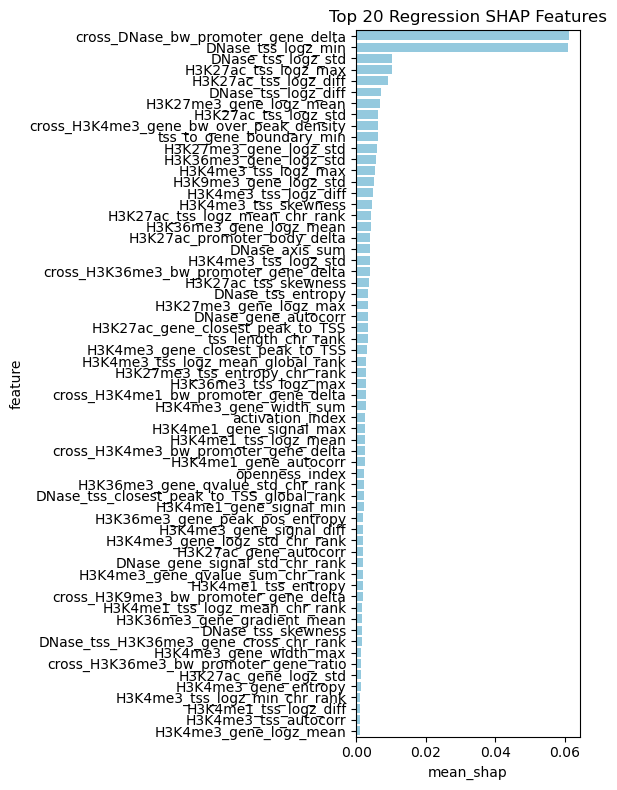

In [150]:
plt.figure(figsize=(6,8))
sns.barplot(data=summary_reg.head(63), y="feature", x="mean_shap", color="skyblue")
plt.title("Top 20 Regression SHAP Features")
plt.tight_layout()
plt.show()


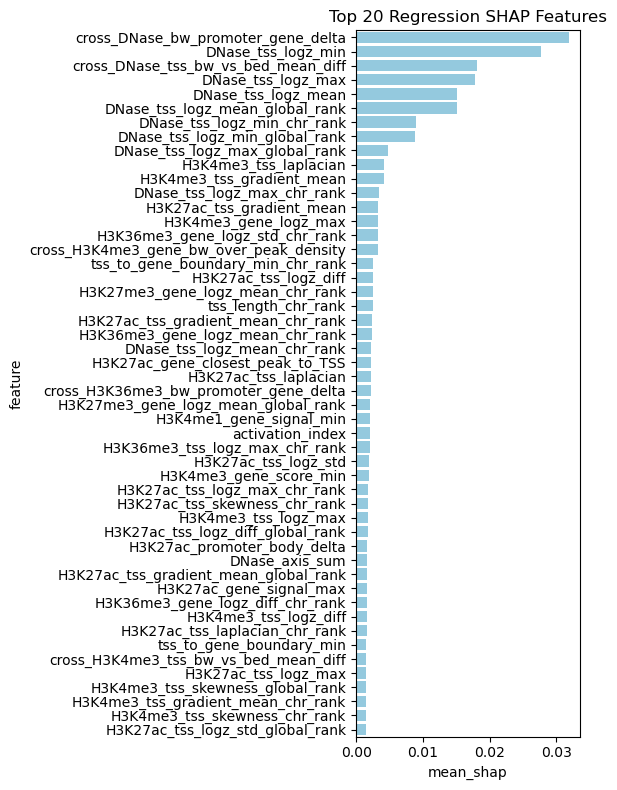

In [93]:
plt.figure(figsize=(6,8))
sns.barplot(data=summary_reg.head(50), y="feature", x="mean_shap", color="skyblue")
plt.title("Top 20 Regression SHAP Features")
plt.tight_layout()
plt.show()


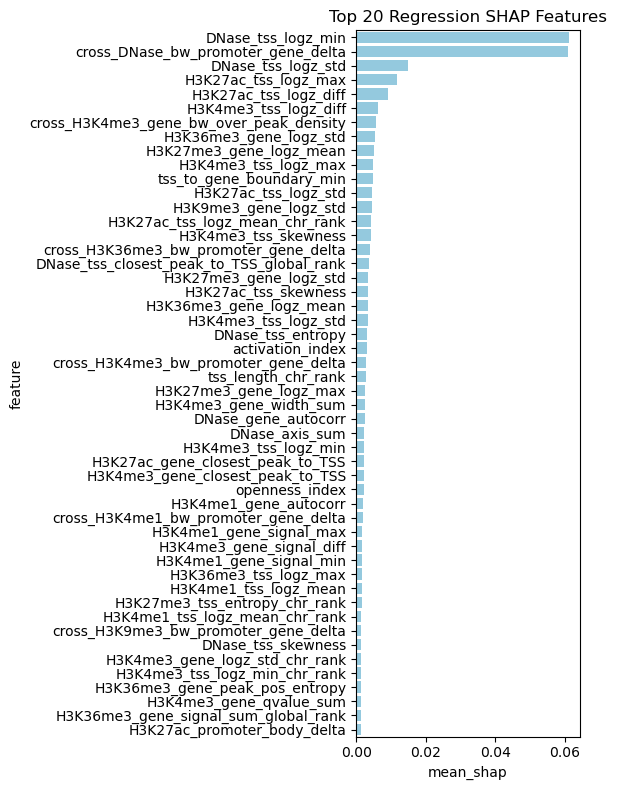

In [84]:
plt.figure(figsize=(6,8))
sns.barplot(data=summary_reg.head(50), y="feature", x="mean_shap", color="skyblue")
plt.title("Top 20 Regression SHAP Features")
plt.tight_layout()
plt.show()


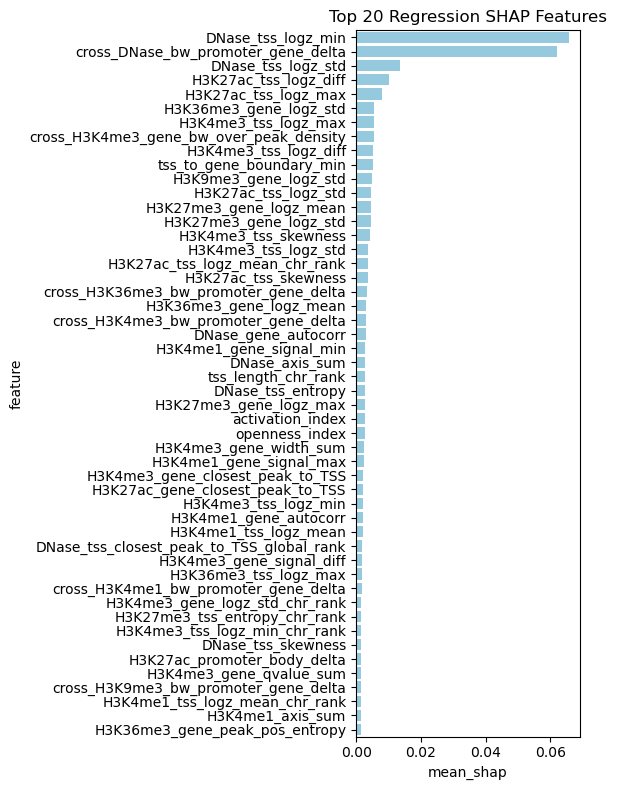

In [75]:
plt.figure(figsize=(6,8))
sns.barplot(data=summary_reg.head(50), y="feature", x="mean_shap", color="skyblue")
plt.title("Top 20 Regression SHAP Features")
plt.tight_layout()
plt.show()



📊 Total feature count (before pruning): 605
✅ Loaded X1: shape=(16284, 2914)
✅ Loaded X2: shape=(16284, 2914)
✅ Loaded X3: shape=(1984, 2914)
🧩 X1: 192 correlated pairs with |r| > 0.99
🧩 X2: 180 correlated pairs with |r| > 0.99
🧩 X3: 250 correlated pairs with |r| > 0.99
📈 Loaded 1122 SHAP scores from binary + regression summaries.

🗑️ Total features to drop (based on SHAP + corr): 186
✅ Remaining features after pruning: 419 (removed 186)

📈 Visualizing correlation matrix for X1 after SHAP-based pruning ...


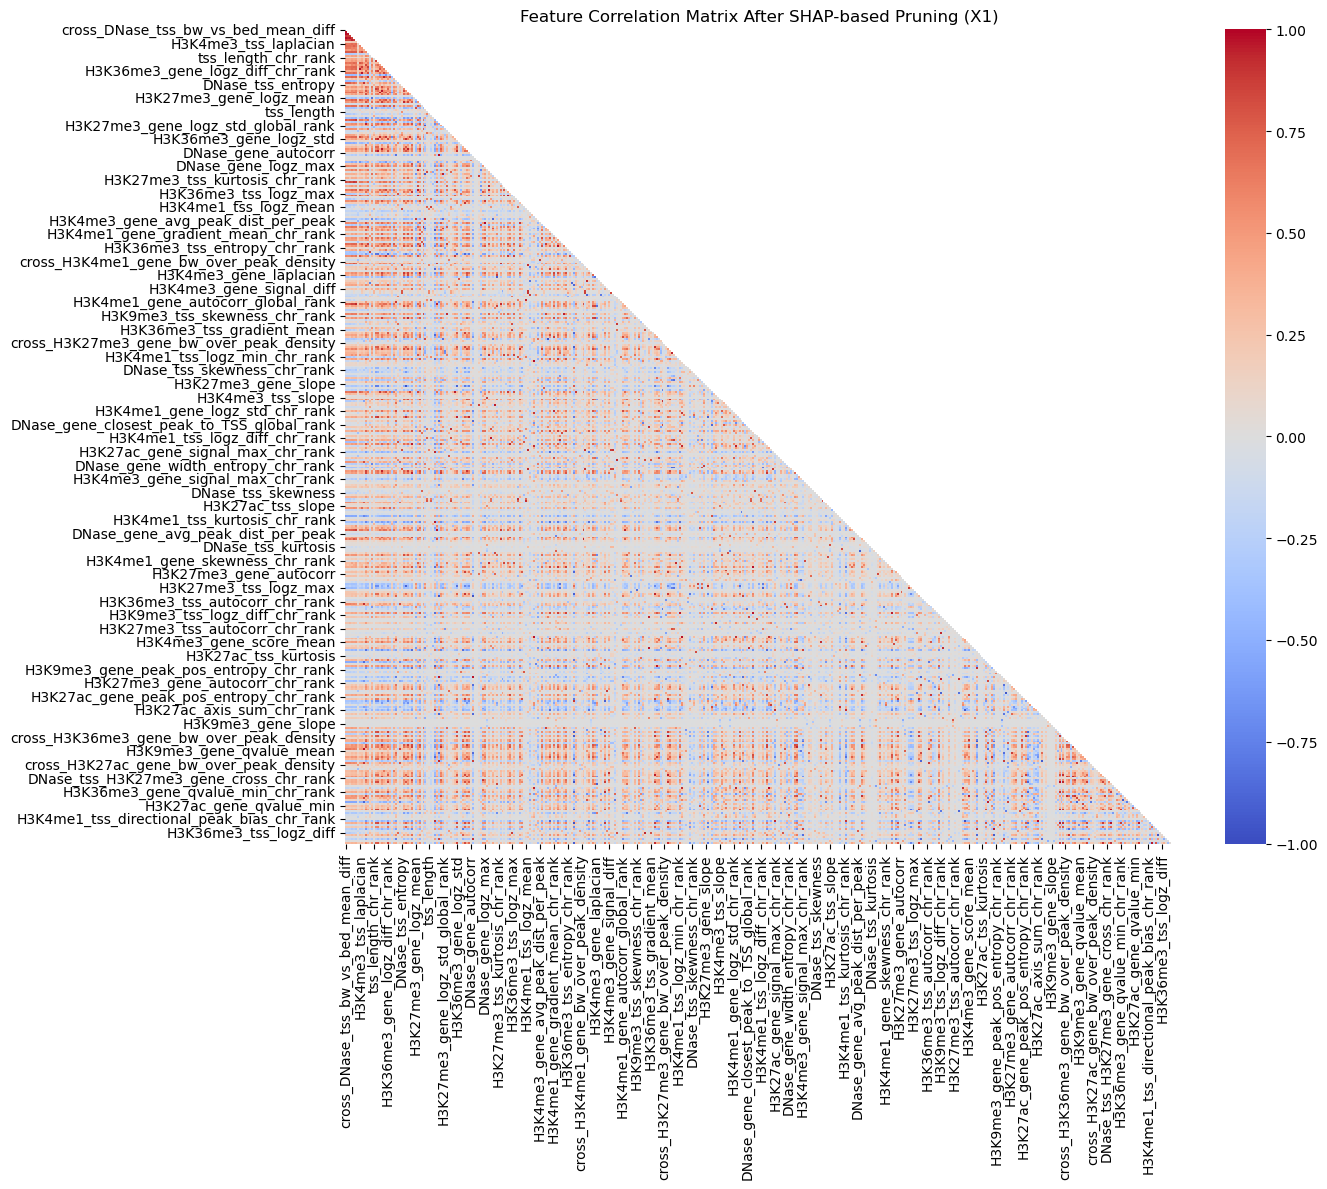

In [102]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================
BASE_PATH = "../preprocessed_data/reference/1. merged data/without_y_100_one_side"
CELLS = ["X1", "X2", "X3"]

BINARY_SUMMARY = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top1000_Union/binary_shap_summary.tsv"
REG_SUMMARY    = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top1000_Union/regression_shap_summary.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "rank_global", "rank_chr"]

THRESHOLD = 0.99  # 高相關閾值
SELECTED_FEATURES = selected_features  # 你原本載入的 features 列表

# ============================================================
# FUNCTION: 找出高相關特徵對
# ============================================================
def get_high_corr_pairs(df, feature_cols, threshold=0.95, method="pearson"):
    X = df[feature_cols]
    corr = X.corr(method=method)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = (
        upper.stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "correlation"})
    )
    pairs = pairs[pairs["correlation"].abs() > threshold]
    return pairs


# ============================================================
# LOAD SHAP SUMMARY
# ============================================================
def load_shap_scores(binary_path, reg_path):
    """合併 binary + regression shap summary"""
    bin_df = pd.read_csv(binary_path, sep="\t")
    reg_df = pd.read_csv(reg_path, sep="\t")

    shap_df = pd.concat([
        bin_df.assign(source="binary"),
        reg_df.assign(source="regression")
    ])
    shap_df = (
        shap_df.groupby("feature", as_index=False)
        .agg(mean_shap_score=("mean_shap", "mean"))
    )
    return shap_df.set_index("feature")["mean_shap_score"].to_dict()


# ============================================================
# LOAD ALL CELLS
# ============================================================
feature_cols = SELECTED_FEATURES
print(f"\n📊 Total feature count (before pruning): {len(feature_cols)}")

dfs = {}
for cell in CELLS:
    path = os.path.join(BASE_PATH, f"{cell}_all_rank_features.tsv")
    if not os.path.exists(path):
        print(f"⚠️ Missing file: {path}")
        continue
    df = pd.read_csv(path, sep="\t")
    dfs[cell] = df[feature_cols]
    print(f"✅ Loaded {cell}: shape={df.shape}")

# ============================================================
# COMPUTE HIGH CORR FEATURES FOR EACH CELL
# ============================================================
high_corr_pairs_per_cell = {}

for cell, df in dfs.items():
    pairs = get_high_corr_pairs(df, feature_cols, threshold=THRESHOLD)
    high_corr_pairs_per_cell[cell] = pairs
    print(f"🧩 {cell}: {len(pairs)} correlated pairs with |r| > {THRESHOLD}")

# ============================================================
# LOAD SHAP SCORES
# ============================================================
shap_scores = load_shap_scores(BINARY_SUMMARY, REG_SUMMARY)
print(f"📈 Loaded {len(shap_scores)} SHAP scores from binary + regression summaries.")

# ============================================================
# DETERMINE WHICH FEATURE TO DROP
# ============================================================
to_drop = set()

for cell, pairs in high_corr_pairs_per_cell.items():
    for _, row in pairs.iterrows():
        f1, f2 = row["feature_1"], row["feature_2"]
        s1 = shap_scores.get(f1, 0)
        s2 = shap_scores.get(f2, 0)

        # 若都沒有 shap 分數，刪掉 feature_2 (任意選一)
        if s1 == 0 and s2 == 0:
            to_drop.add(f2)
        else:
            drop_f = f1 if s1 < s2 else f2
            to_drop.add(drop_f)

print(f"\n🗑️ Total features to drop (based on SHAP + corr): {len(to_drop)}")

# ============================================================
# PRUNE FEATURES
# ============================================================
features_pruned = [f for f in feature_cols if f not in to_drop]
print(f"✅ Remaining features after pruning: {len(features_pruned)} (removed {len(to_drop)})")

# ============================================================
# SAVE PRUNED DATASETS
# ============================================================
# for cell, df in dfs.items():
#     df_pruned = df[features_pruned]
#     out_path = os.path.join(BASE_PATH, f"{cell}_all_features_shap_pruned.tsv")
#     df_pruned.to_csv(out_path, sep="\t", index=False)
#     print(f"💾 Saved SHAP-pruned {cell} → {out_path} (shape={df_pruned.shape})")

# ============================================================
# OPTIONAL: VISUALIZATION
# ============================================================
if "X1" in dfs:
    print("\n📈 Visualizing correlation matrix for X1 after SHAP-based pruning ...")
    plt.figure(figsize=(14, 12))
    corr = dfs["X1"][features_pruned].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix After SHAP-based Pruning (X1)")
    plt.tight_layout()
    plt.show()



📊 Total feature count (before pruning): 239
✅ Loaded X1: shape=(16284, 2914)
✅ Loaded X2: shape=(16284, 2914)
✅ Loaded X3: shape=(1984, 2914)

🧹 Removing sparse features (non-zero ratio < 1.00%) ...
🚫 Found 0 sparse features to remove (avg non-zero ratio < 0.01)
✅ Remaining features after sparsity filtering: 239
🧩 X1: 379 correlated pairs → 146 features with |r| > 0.99
🧩 X2: 306 correlated pairs → 142 features with |r| > 0.99
🧩 X3: 802 correlated pairs → 162 features with |r| > 0.99

🔗 Union (any cell) high corr features: 164
🔗 Intersection (all cell) high corr features: 134

✅ Remaining features after pruning: 75 (removed 164)

📈 Visualizing correlation matrix for X1 after pruning ...


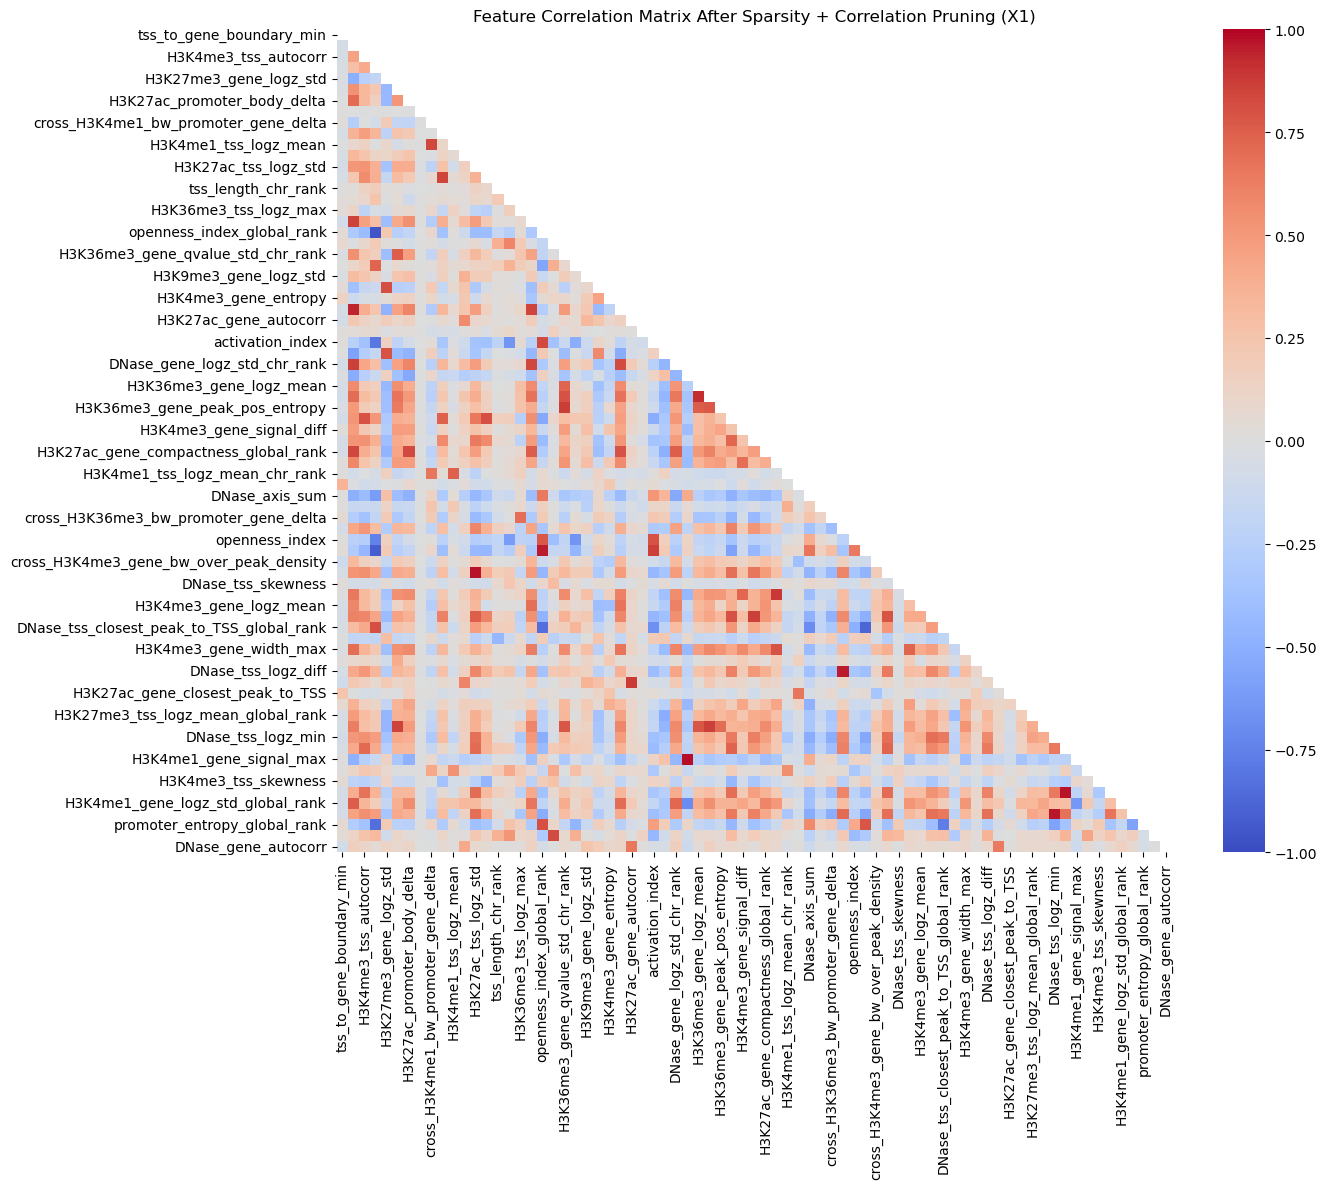

In [152]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================
BASE_PATH = "../preprocessed_data/reference/1. merged data/without_y_100_one_side"
CELLS = ["X1", "X2", "X3"]

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "rank_global", "rank_chr"]

THRESHOLD = 0.99  # 高相關閾值
SPARSITY_THRESHOLD = 0.01  # 小於此比例的非零值會被刪除（例如 <1% 非零）

# ============================================================
# FUNCTION: 找出高相關特徵對
# ============================================================
def get_high_corr_pairs(df, feature_cols, threshold=0.95, method="pearson"):
    X = df[feature_cols]
    corr = X.corr(method=method)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = (
        upper.stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "correlation"})
    )
    pairs = pairs[pairs["correlation"].abs() > threshold]
    return pairs


# ============================================================
# LOAD ALL CELLS
# ============================================================
feature_cols = selected_features
print(f"\n📊 Total feature count (before pruning): {len(feature_cols)}")

dfs = {}
for cell in CELLS:
    path = os.path.join(BASE_PATH, f"{cell}_all_rank_features.tsv")
    if not os.path.exists(path):
        print(f"⚠️ Missing file: {path}")
        continue
    df = pd.read_csv(path, sep="\t")
    dfs[cell] = df[feature_cols]
    print(f"✅ Loaded {cell}: shape={df.shape}")

# ============================================================
# === 新增區塊：移除幾乎全為 0 的特徵 ===
# ============================================================
def remove_sparse_features(dfs, feature_cols, threshold=0.01):
    """
    移除非零比例過低（太稀疏）的特徵。
    threshold=0.01 表示若 <1% 非零值就刪除。
    """
    print(f"\n🧹 Removing sparse features (non-zero ratio < {threshold:.2%}) ...")
    zero_stats = []

    for f in feature_cols:
        # 計算在所有 cell 合併後的非零比例
        non_zero_ratio = np.mean([
            np.count_nonzero(dfs[cell][f].values) / len(dfs[cell])
            for cell in dfs
            if f in dfs[cell].columns
        ])
        zero_stats.append((f, non_zero_ratio))

    zero_df = pd.DataFrame(zero_stats, columns=["feature", "nonzero_ratio"])
    sparse_feats = zero_df.loc[zero_df["nonzero_ratio"] < threshold, "feature"].tolist()

    print(f"🚫 Found {len(sparse_feats)} sparse features to remove (avg non-zero ratio < {threshold})")

    # 回傳保留後的 feature 列表
    kept_feats = [f for f in feature_cols if f not in sparse_feats]
    return kept_feats, zero_df

# --- 執行稀疏特徵過濾 ---
feature_cols, zero_df = remove_sparse_features(dfs, feature_cols, threshold=SPARSITY_THRESHOLD)
print(f"✅ Remaining features after sparsity filtering: {len(feature_cols)}")

# ============================================================
# COMPUTE HIGH CORR FEATURES FOR EACH CELL
# ============================================================
high_corr_feats_per_cell = {}

for cell, df in dfs.items():
    pairs = get_high_corr_pairs(df, feature_cols, threshold=THRESHOLD)
    high_corr_feats = set(pairs["feature_1"]) | set(pairs["feature_2"])
    high_corr_feats_per_cell[cell] = high_corr_feats
    print(f"🧩 {cell}: {len(pairs)} correlated pairs → {len(high_corr_feats)} features with |r| > {THRESHOLD}")

# ============================================================
# COMBINE RESULTS ACROSS CELLS
# ============================================================
union_feats = set().union(*high_corr_feats_per_cell.values())
intersection_feats = set.intersection(*high_corr_feats_per_cell.values())

print(f"\n🔗 Union (any cell) high corr features: {len(union_feats)}")
print(f"🔗 Intersection (all cell) high corr features: {len(intersection_feats)}")

# ============================================================
# DROP REDUNDANT FEATURES (use union)
# ============================================================
features_pruned = [f for f in feature_cols if f not in union_feats]
print(f"\n✅ Remaining features after pruning: {len(features_pruned)} (removed {len(union_feats)})")

# ============================================================
# SAVE PRUNED DATASETS
# ============================================================
# for cell, df in dfs.items():
#     df_pruned = df[META_COLS + features_pruned]
#     out_path = os.path.join(BASE_PATH, f"{cell}_all_features_with_bed_pruned.tsv")
#     df_pruned.to_csv(out_path, sep="\t", index=False)
#     print(f"💾 Saved pruned {cell} → {out_path} (shape={df_pruned.shape})")

# ============================================================
# Optional: 可視化
# ============================================================
if "X1" in dfs:
    print("\n📈 Visualizing correlation matrix for X1 after pruning ...")
    plt.figure(figsize=(14, 12))
    corr = dfs["X1"][features_pruned].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix After Sparsity + Correlation Pruning (X1)")
    plt.tight_layout()
    plt.show()


✅ Loaded X1: shape=(16284, 2901)
✅ Loaded X2: shape=(16284, 2901)

🔗 Computing feature–gex correlations (Pearson + Spearman) ...
✅ Computed correlations for 63 features.

🏆 Top correlated features with gex (by |Spearman|):


,feature,pearson_mean,pearson_std,spearman_mean,spearman_std,abs_spearman,abs_pearson
7,DNase_tss_logz_min,0.201084,0.100467,0.707791,0.072817,0.707791,0.201084
53,cross_DNase_bw_promoter_gene_delta,0.199942,0.067510,0.702067,0.020039,0.702067,0.199942
45,H3K4me3_tss_logz_diff,0.188192,0.020463,0.667969,0.020775,0.667969,0.188192
49,H3K4me3_tss_logz_std,0.194378,0.017996,0.663141,0.028345,0.663141,0.194378
46,H3K4me3_tss_logz_max,0.165585,0.005566,0.645812,0.020206,0.645812,0.165585
8,DNase_tss_logz_std,0.131193,0.021166,0.643389,0.047688,0.643389,0.131193
54,cross_H3K36me3_bw_promoter_gene_delta,-0.198773,0.033006,-0.569682,0.049694,0.569682,0.198773
5,DNase_tss_closest_peak_to_TSS_global_rank,0.152140,0.025483,0.567463,0.010956,0.567463,0.152140
14,H3K27ac_tss_logz_diff,0.159784,0.086972,0.509973,0.239231,0.509973,0.159784
52,activation_index,-0.087320,0.011852,-0.503189,0.006254,0.503189,0.087320


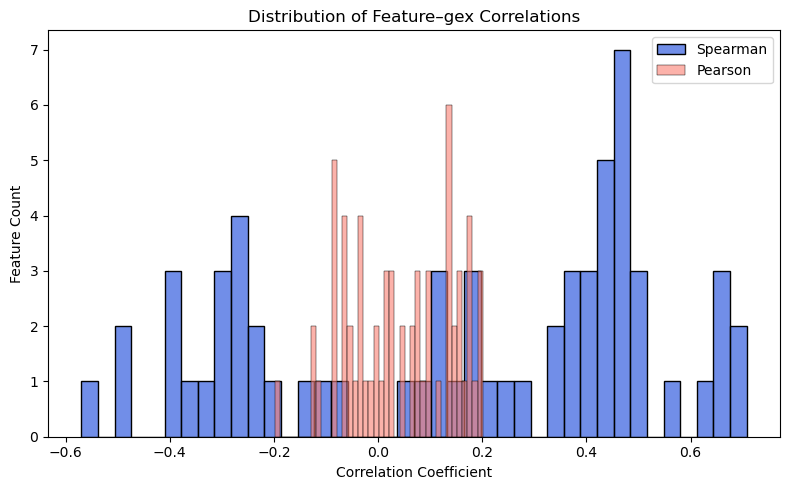

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ============================================================
# CONFIG
# ============================================================
BASE_PATH = "../preprocessed_data/reference/1. merged data/with_y_100_one_side"
CELLS = ["X1", "X2"]   # ✅ 這裡改成只有有 gex 的 cell


# ============================================================
# FUNCTION: 計算 Feature–GEX 相關性
# ============================================================
def compute_feature_target_correlation(dfs, feature_cols, target_col="gex"):
    """
    計算每個特徵與 gex 的 Pearson / Spearman 相關係數
    在每個 cell 單獨計算，並給出平均與標準差
    """
    print("\n🔗 Computing feature–gex correlations (Pearson + Spearman) ...")

    corr_rows = []
    for cell, df in dfs.items():
        if target_col not in df.columns:
            print(f"⚠️ Missing {target_col} in {cell}, skipping correlation.")
            continue
        for f in feature_cols:
            try:
                pearson_r = np.corrcoef(df[f], df[target_col])[0, 1]
                spearman_r, _ = spearmanr(df[f], df[target_col])
            except Exception:
                pearson_r, spearman_r = np.nan, np.nan
            corr_rows.append({
                "cell": cell,
                "feature": f,
                "pearson_r": pearson_r,
                "spearman_r": spearman_r
            })

    corr_df = pd.DataFrame(corr_rows)
    corr_summary = (
        corr_df.groupby("feature", as_index=False)
        .agg(
            pearson_mean=("pearson_r", "mean"),
            pearson_std=("pearson_r", "std"),
            spearman_mean=("spearman_r", "mean"),
            spearman_std=("spearman_r", "std"),
        )
    )
    corr_summary["abs_spearman"] = corr_summary["spearman_mean"].abs()
    corr_summary["abs_pearson"] = corr_summary["pearson_mean"].abs()

    corr_summary.sort_values("abs_spearman", ascending=False, inplace=True)
    print(f"✅ Computed correlations for {len(corr_summary)} features.")

    return corr_summary

# ============================================================
# LOAD DATA
# ============================================================
# 假設你已經有 selected_features 清單
feature_cols = selected_features

dfs = {}
for cell in CELLS:
    path = os.path.join(BASE_PATH, f"{cell}_all_rank_features_with_y.tsv")
    if not os.path.exists(path):
        print(f"⚠️ Missing file: {path}")
        continue
    df = pd.read_csv(path, sep="\t")
    dfs[cell] = df
    print(f"✅ Loaded {cell}: shape={df.shape}")

# ============================================================
# STEP 2: 計算 feature–gex correlation
# ============================================================
corr_summary = compute_feature_target_correlation(dfs, feature_cols, target_col="gex")

# 顯示前 10 名
print("\n🏆 Top correlated features with gex (by |Spearman|):")
display(corr_summary.head(10))

# ============================================================
# STEP 3: 可視化分佈
# ============================================================
plt.figure(figsize=(8,5))
sns.histplot(corr_summary["spearman_mean"], bins=40, color="royalblue", label="Spearman")
sns.histplot(corr_summary["pearson_mean"], bins=40, color="salmon", alpha=0.6, label="Pearson")
plt.legend()
plt.title("Distribution of Feature–gex Correlations")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature Count")
plt.tight_layout()
plt.show()


In [140]:
corr_summary = compute_feature_target_correlation(dfs, [c for c in list(dfs[CELLS[0]].columns) if c not in META_COLS], target_col="gex")
corr_summary.sort_values("abs_spearman", ascending=False, inplace=True)
print("\n🏆 Top correlated features with gex (by |Spearman|):")


🔗 Computing feature–gex correlations (Pearson + Spearman) ...


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74266/2220869888.py:33: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_r, _ = spearmanr(df[f], df[target_col])


✅ Computed correlations for 2893 features.

🏆 Top correlated features with gex (by |Spearman|):


In [151]:
# 取出前 50 個 feature 名稱（排除 gex_rank）
top_features = corr_summary.head(200)["feature"].tolist()
top_features = [f for f in top_features if f != "gex_rank"]

# 加入到 selected_features（不重複）
selected_features = list(set(selected_features) | set(top_features))

print(f"✅ Updated selected_features: {len(selected_features)} total")


✅ Updated selected_features: 239 total



📊 Total feature count (before pruning): 63
✅ Loaded X1: shape=(16284, 2914)
✅ Loaded X2: shape=(16284, 2914)
✅ Loaded X3: shape=(1984, 2914)
🧩 X1: 0 correlated pairs → 0 features with |r| > 0.99
🧩 X2: 0 correlated pairs → 0 features with |r| > 0.99
🧩 X3: 0 correlated pairs → 0 features with |r| > 0.99

🔗 Union (any cell) high corr features: 0
🔗 Intersection (all cells) high corr features: 0

✅ Remaining features after pruning: 63 (removed 0)

📈 Visualizing correlation matrix for X1 after pruning ...


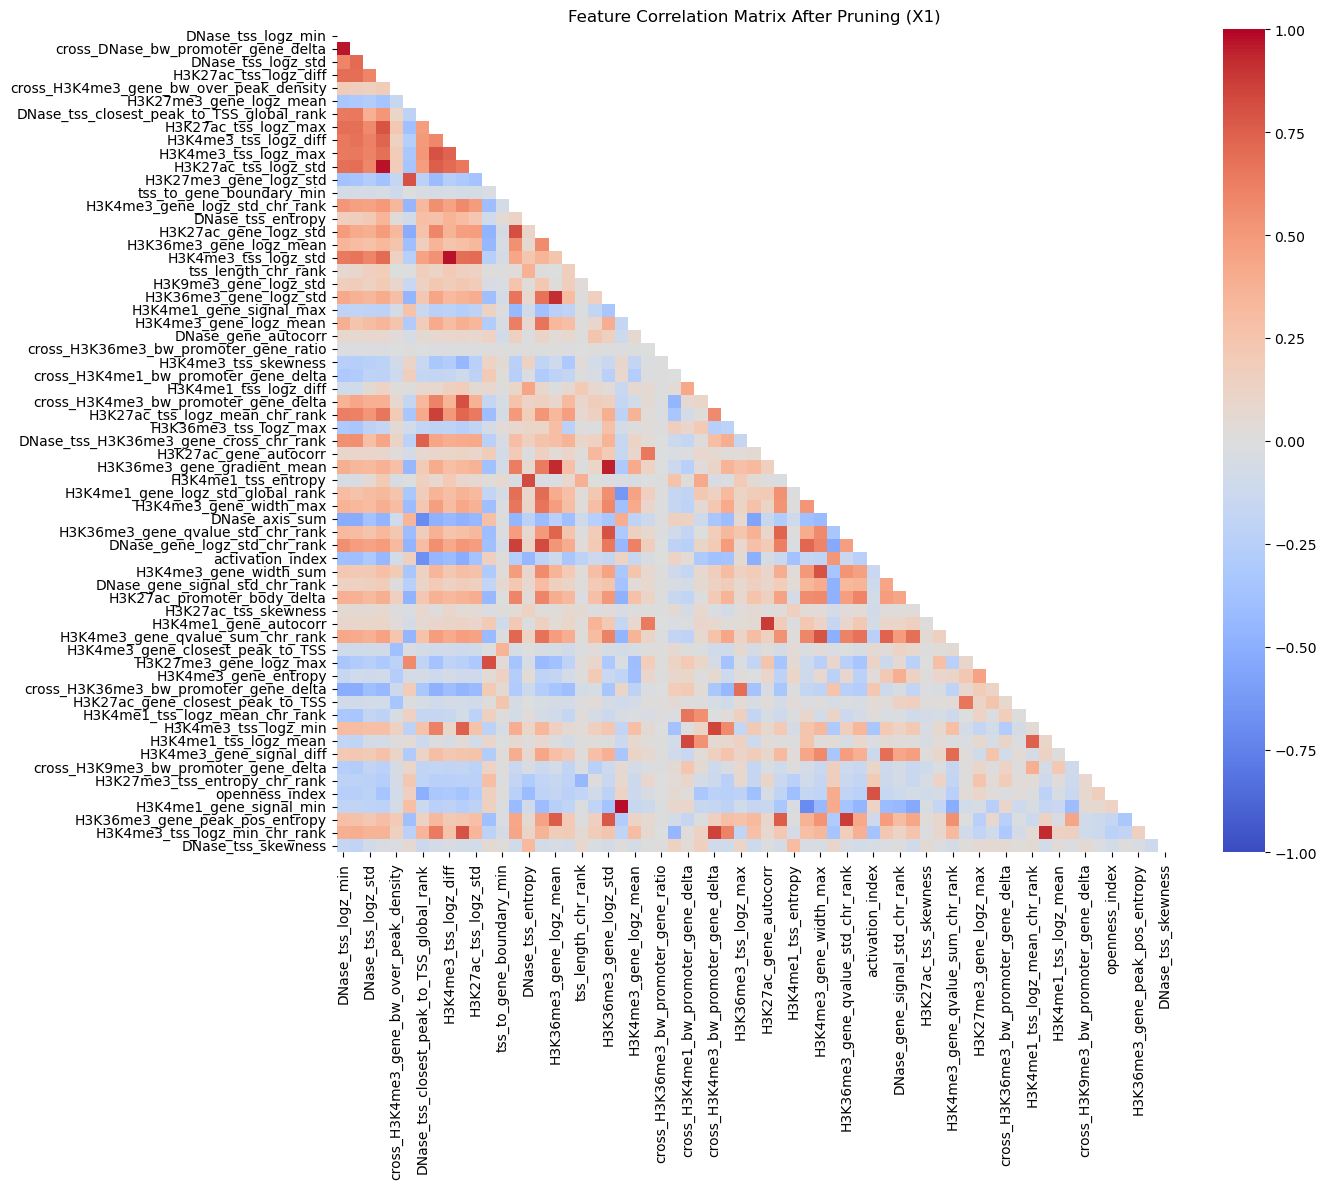

In [ ]:
binary_summary = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top1000_Union/binary_shap_summary.tsv"
reg_summary    = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/top1000_Union/regression_shap_summary.tsv"

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================
BASE_PATH = "../preprocessed_data/reference/1. merged data/without_y_100_one_side"
CELLS = ["X1", "X2", "X3"]

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "rank_global", "rank_chr"]

THRESHOLD = 0.99  # 高相關閾值

# ============================================================
# FUNCTION: 找出高相關特徵對
# ============================================================
def get_high_corr_pairs(df, feature_cols, threshold=0.95, method="pearson"):
    X = df[feature_cols]
    corr = X.corr(method=method)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = (
        upper.stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "correlation"})
    )
    pairs = pairs[pairs["correlation"].abs() > threshold]
    return pairs


# ============================================================
# LOAD ALL CELLS
# ============================================================
# 取得 feature columns（假設所有 cell 一致）
feature_cols = selected_features
print(f"\n📊 Total feature count (before pruning): {len(feature_cols)}")

dfs = {}
for cell in CELLS:
    path = os.path.join(BASE_PATH, f"{cell}_all_rank_features.tsv")
    if not os.path.exists(path):
        print(f"⚠️ Missing file: {path}")
        continue
    df = pd.read_csv(path, sep="\t")
    dfs[cell] = df[feature_cols]
    print(f"✅ Loaded {cell}: shape={df.shape}")


# ============================================================
# COMPUTE HIGH CORR FEATURES FOR EACH CELL
# ============================================================
high_corr_feats_per_cell = {}

for cell, df in dfs.items():
    pairs = get_high_corr_pairs(df, feature_cols, threshold=THRESHOLD)
    high_corr_feats = set(pairs["feature_1"]) | set(pairs["feature_2"])
    high_corr_feats_per_cell[cell] = high_corr_feats
    print(f"🧩 {cell}: {len(pairs)} correlated pairs → {len(high_corr_feats)} features with |r| > {THRESHOLD}")

# ============================================================
# COMBINE RESULTS ACROSS CELLS
# ============================================================
# --- 取聯集 (任何一個 cell 高相關就移除) ---
union_feats = set().union(*high_corr_feats_per_cell.values())

# --- 取交集 (所有 cell 都高相關才移除) ---
intersection_feats = set.intersection(*high_corr_feats_per_cell.values())

print(f"\n🔗 Union (any cell) high corr features: {len(union_feats)}")
print(f"🔗 Intersection (all cells) high corr features: {len(intersection_feats)}")

# ============================================================
# DROP REDUNDANT FEATURES (use union)
# ============================================================
features_pruned = [f for f in feature_cols if f not in union_feats]
print(f"\n✅ Remaining features after pruning: {len(features_pruned)} (removed {len(union_feats)})")

# ============================================================
# SAVE PRUNED DATASETS
# ============================================================
# for cell, df in dfs.items():
#     # --- 自動補上缺少的 META_COLS ---
#     missing_meta = [c for c in META_COLS if c not in df.columns]
#     if missing_meta:
#         print(f"⚠️ {cell} 缺少欄位 {missing_meta} → 自動補為 0.0")
#         for c in missing_meta:
#             df[c] = 0.0
#     df_pruned = df[META_COLS + features_pruned]
#     out_path = os.path.join(BASE_PATH, f"{cell}_all_features_with_bed_pruned.tsv")
#     df_pruned.to_csv(out_path, sep="\t", index=False)
#     print(f"💾 Saved pruned {cell} → {out_path} (shape={df_pruned.shape})")

# ============================================================
# Optional: 可視化 (以 X1 為例)
# ============================================================
if "X1" in dfs:
    print("\n📈 Visualizing correlation matrix for X1 after pruning ...")
    plt.figure(figsize=(14, 12))
    corr = dfs["X1"][features_pruned].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix After Pruning (X1)")
    plt.tight_layout()
    plt.show()


⚠️ X1 缺少欄位 ['gex', 'rank_global', 'rank_chr'] → 自動補為 0.0
💾 Saved pruned X1 → ../preprocessed_data/reference/1. quantile_normalized/X1_all_features_with_bed_pruned.tsv (shape=(16284, 226))
⚠️ X2 缺少欄位 ['gex', 'rank_global', 'rank_chr'] → 自動補為 0.0
💾 Saved pruned X2 → ../preprocessed_data/reference/1. quantile_normalized/X2_all_features_with_bed_pruned.tsv (shape=(16284, 226))
⚠️ X3 缺少欄位 ['gex', 'rank_global', 'rank_chr'] → 自動補為 0.0
💾 Saved pruned X3 → ../preprocessed_data/reference/1. quantile_normalized/X3_all_features_with_bed_pruned.tsv (shape=(1984, 226))

📈 Visualizing correlation matrix for X1 after pruning ...


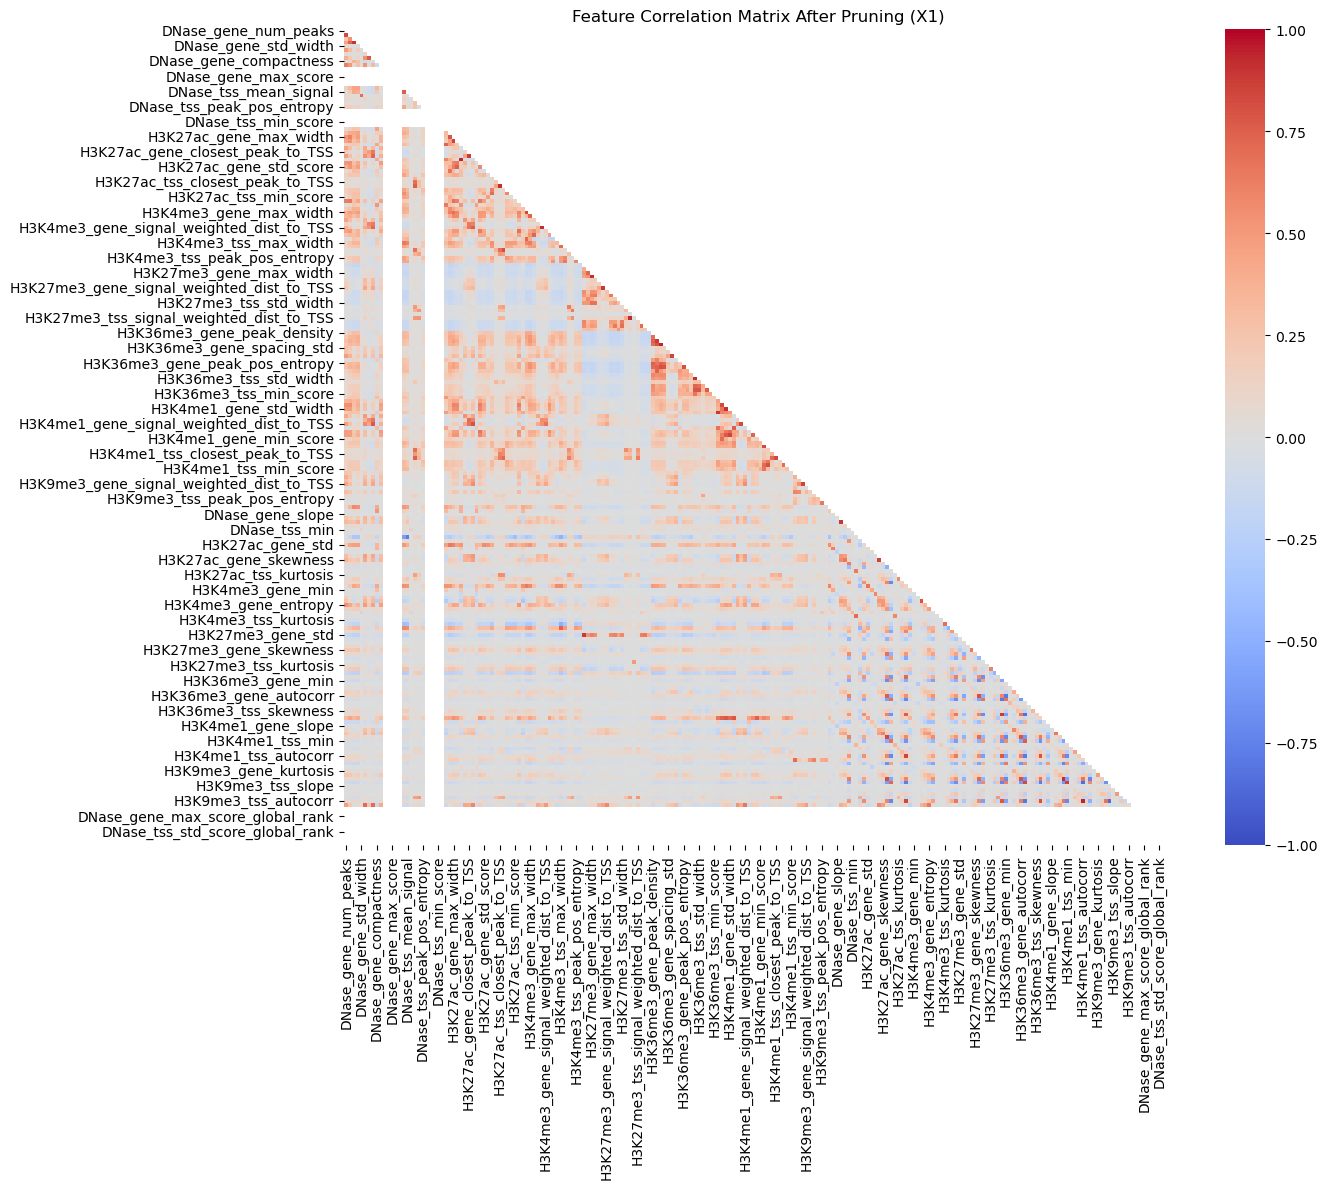

In [5]:
for cell, df in dfs.items():
    # --- 自動補上缺少的 META_COLS ---
    missing_meta = [c for c in META_COLS if c not in df.columns]
    if missing_meta:
        print(f"⚠️ {cell} 缺少欄位 {missing_meta} → 自動補為 0.0")
        for c in missing_meta:
            df[c] = 0.0
    df_pruned = df[META_COLS + features_pruned]
    out_path = os.path.join(BASE_PATH, f"{cell}_all_features_with_bed_pruned.tsv")
    df_pruned.to_csv(out_path, sep="\t", index=False)
    print(f"💾 Saved pruned {cell} → {out_path} (shape={df_pruned.shape})")

# ============================================================
# Optional: 可視化 (以 X1 為例)
# ============================================================
if "X1" in dfs:
    print("\n📈 Visualizing correlation matrix for X1 after pruning ...")
    plt.figure(figsize=(14, 12))
    corr = dfs["X1"][features_pruned].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix After Pruning (X1)")
    plt.tight_layout()
    plt.show()


In [6]:
features_pruned

['DNase_gene_num_peaks',
 'DNase_gene_sum_signal',
 'DNase_gene_mean_signal',
 'DNase_gene_max_signal',
 'DNase_gene_std_width',
 'DNase_gene_spacing_std',
 'DNase_gene_closest_peak_to_TSS',
 'DNase_gene_signal_weighted_dist_to_TSS',
 'DNase_gene_compactness',
 'DNase_gene_peak_pos_entropy',
 'DNase_gene_mean_score',
 'DNase_gene_std_score',
 'DNase_gene_max_score',
 'DNase_gene_min_score',
 'DNase_gene_sum_score',
 'DNase_tss_sum_signal',
 'DNase_tss_mean_signal',
 'DNase_tss_std_width',
 'DNase_tss_spacing_std',
 'DNase_tss_closest_peak_to_TSS',
 'DNase_tss_peak_pos_entropy',
 'DNase_tss_mean_score',
 'DNase_tss_std_score',
 'DNase_tss_max_score',
 'DNase_tss_min_score',
 'DNase_tss_sum_score',
 'H3K27ac_gene_peak_density',
 'H3K27ac_gene_mean_width',
 'H3K27ac_gene_max_width',
 'H3K27ac_gene_std_width',
 'H3K27ac_gene_coverage_ratio',
 'H3K27ac_gene_spacing_std',
 'H3K27ac_gene_closest_peak_to_TSS',
 'H3K27ac_gene_signal_weighted_dist_to_TSS',
 'H3K27ac_gene_compactness',
 'H3K27ac_

In [8]:
df_qn

,gene_name,chr,gene_start,gene_end,TSS_start,TSS_end,strand,gex,rank_global,rank_chr,...,DNase_gene_mean_score_global_rank,DNase_gene_std_score_global_rank,DNase_gene_max_score_global_rank,DNase_gene_min_score_global_rank,DNase_gene_sum_score_global_rank,DNase_tss_mean_score_global_rank,DNase_tss_std_score_global_rank,DNase_tss_max_score_global_rank,DNase_tss_min_score_global_rank,DNase_tss_sum_score_global_rank
0,A1BG,chr19,58345178,58353492,58353079,58353129,-,0.0,0.0,0.0,...,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031
1,A1CF,chr10,50799409,50885675,50828411,50828461,-,0.0,0.0,0.0,...,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031
2,A2M,chr12,9067664,9116229,9106246,9106296,-,0.0,0.0,0.0,...,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031
3,A2ML1,chr12,8822621,8887001,8822471,8845003,+,0.0,0.0,0.0,...,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031
4,A4GALT,chr22,42692121,42721298,42695583,42721298,-,0.0,0.0,0.0,...,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16279,ZWILCH,chr15,66504959,66550130,66505294,66505344,+,0.0,0.0,0.0,...,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031
16280,ZWINT,chr10,56357227,56361273,56359708,56359758,-,0.0,0.0,0.0,...,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031
16281,ZXDC,chr3,126437601,126475891,126475869,126475919,-,0.0,0.0,0.0,...,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031
16282,ZYX,chr7,143381295,143391111,143381360,143381410,+,0.0,0.0,0.0,...,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031,0.500031


In [9]:
import os
import pandas as pd

# ============================================================
#                  基本設定
# ============================================================
raw_dir = "../preprocessed_data/reference/0. raw_data"
qn_dir = "../preprocessed_data/reference/1. quantile_normalized"
output_dir = "../preprocessed_data/reference/2. features_engineered_selected"
os.makedirs(output_dir, exist_ok=True)

cells = ["X1", "X2"]

# ============================================================
#                  主流程
# ============================================================
for cell in cells:
    y_path = os.path.join(raw_dir, f"{cell}_y.tsv")
    qn_path = os.path.join(qn_dir, f"{cell}_all_features_with_bed_pruned.tsv")
    out_path = os.path.join(output_dir, f"{cell}_all_features_with_bed_pruned_and_y.tsv")

    print(f"\n=== 🧬 {cell}: dense normalized rank (0–1) + replace gex/ranks in QN ===")

    if not os.path.exists(y_path):
        print(f"⚠️ Missing Y file: {y_path}")
        continue
    if not os.path.exists(qn_path):
        print(f"⚠️ Missing QN file: {qn_path}")
        continue

    # --- 讀取 ---
    df_y = pd.read_csv(y_path, sep="\t")
    df_qn = pd.read_csv(qn_path, sep="\t")

    if "gene_name" not in df_y.columns or "gene_name" not in df_qn.columns:
        raise ValueError(f"❌ Missing 'gene_name' column in {cell}")
    if "gex" not in df_y.columns:
        raise ValueError(f"❌ Missing 'gex' column in {cell}_y.tsv")

    print(f"📘 Loaded y={df_y.shape}, qn={df_qn.shape}")

    # ============================================================
    # 🧮 Step 1. 建立新的 normalized rank
    # ============================================================
    df_y["rank_global"] = df_y["gex"].rank(method="dense", ascending=True)
    df_y["rank_global"] = (df_y["rank_global"] - 1) / (df_y["rank_global"].max() - 1)

    if "chr" in df_y.columns:
        df_y["rank_chr"] = df_y.groupby("chr")["gex"].rank(method="dense", ascending=True)
        df_y["rank_chr"] = df_y.groupby("chr")["rank_chr"].transform(
            lambda x: (x - 1) / (x.max() - 1) if x.max() > 1 else 0
        )
    else:
        print("⚠️ No 'chr' column found in y file — using global rank for rank_chr")
        df_y["rank_chr"] = df_y["rank_global"]

    # ============================================================
    # 🧩 Step 2. 先刪掉 QN 裡舊的欄位，再 merge 新的
    # ============================================================
    drop_cols = [c for c in ["gex", "rank_global", "rank_chr"] if c in df_qn.columns]
    if drop_cols:
        print(f"🧹 Dropping old columns from QN: {drop_cols}")
        df_qn = df_qn.drop(columns=drop_cols)

    df_merged = pd.merge(df_qn, df_y[["gene_name", "gex", "rank_global", "rank_chr"]],
                         on="gene_name", how="left")

    # 填補遺漏值
    df_merged = df_merged.fillna(0.0)

    # 排序輸出
    df_merged = df_merged.sort_values("gene_name").reset_index(drop=True)

    # ============================================================
    # 💾 儲存
    # ============================================================
    print(f"✅ Merged shape: {df_merged.shape}")
    df_merged.to_csv(out_path, sep="\t", index=False)
    print(f"💾 Saved → {out_path}")



=== 🧬 X1: dense normalized rank (0–1) + replace gex/ranks in QN ===
📘 Loaded y=(16284, 2), qn=(16284, 226)
⚠️ No 'chr' column found in y file — using global rank for rank_chr
🧹 Dropping old columns from QN: ['gex', 'rank_global', 'rank_chr']
✅ Merged shape: (16284, 226)
💾 Saved → ../preprocessed_data/reference/2. features_engineered_selected/X1_all_features_with_bed_pruned_and_y.tsv

=== 🧬 X2: dense normalized rank (0–1) + replace gex/ranks in QN ===
📘 Loaded y=(16284, 2), qn=(16284, 226)
⚠️ No 'chr' column found in y file — using global rank for rank_chr
🧹 Dropping old columns from QN: ['gex', 'rank_global', 'rank_chr']
✅ Merged shape: (16284, 226)
💾 Saved → ../preprocessed_data/reference/2. features_engineered_selected/X2_all_features_with_bed_pruned_and_y.tsv


✅ Loaded X1: shape=(16284, 2035)
✅ Loaded X2: shape=(16284, 2035)
✅ Loaded X3: shape=(1984, 2035)

📊 Total feature count (before pruning): 2028

=== 🧬 Processing X1 per chromosome ===


100%|██████████| 21/21 [01:24<00:00,  4.01s/it]



=== 🧬 Processing X2 per chromosome ===


100%|██████████| 21/21 [01:25<00:00,  4.08s/it]



=== 🧬 Processing X3 per chromosome ===


100%|██████████| 1/1 [00:10<00:00, 10.17s/it]



🔗 Union of high-corr features across all cell × chr: 1835
✅ Remaining features after pruning: 193 (removed 1835)
💾 Saved pruned X1 → ../preprocessed_data/reference/1. merged data/without_y_100_one_side/X1_all_features_with_bed_chrPruned.tsv (shape=(16284, 200))
💾 Saved pruned X2 → ../preprocessed_data/reference/1. merged data/without_y_100_one_side/X2_all_features_with_bed_chrPruned.tsv (shape=(16284, 200))
💾 Saved pruned X3 → ../preprocessed_data/reference/1. merged data/without_y_100_one_side/X3_all_features_with_bed_chrPruned.tsv (shape=(1984, 200))

📈 Visualizing correlation matrix for X1 after pruning ...


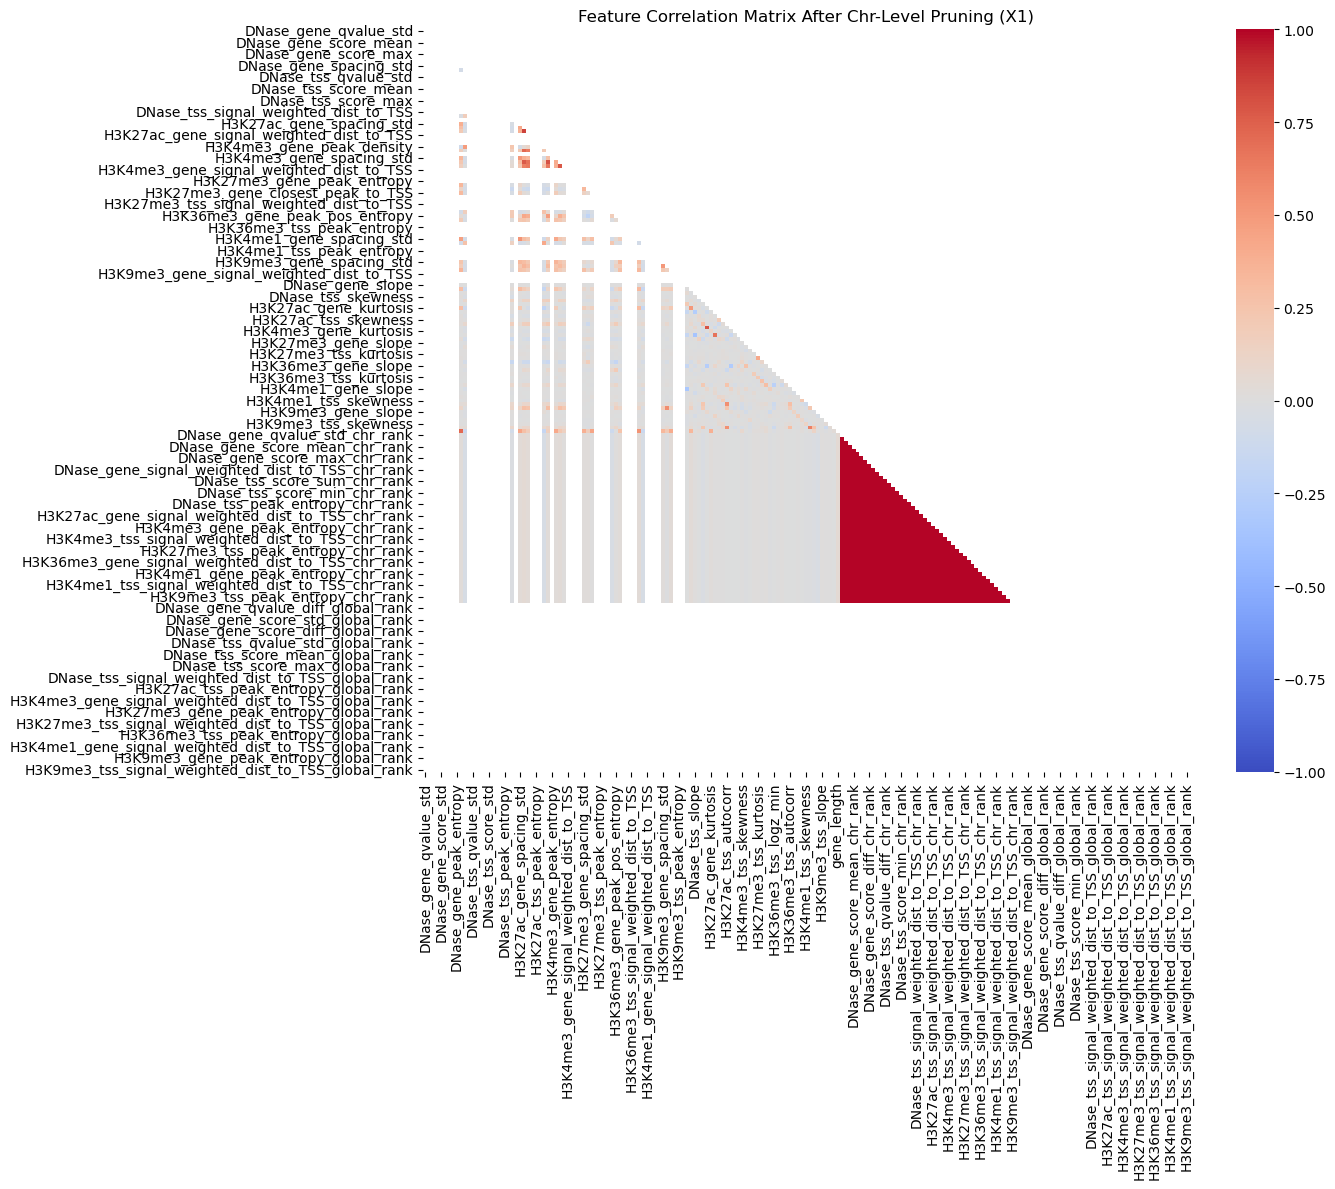

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================================================
# CONFIG
# ============================================================
BASE_PATH = "../preprocessed_data/reference/1. merged data/without_y_100_one_side"
CELLS = ["X1", "X2", "X3"]

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand"]

THRESHOLD = 0.95  # 高相關閾值

# ============================================================
# FUNCTION: 找出高相關特徵對 (for a subset)
# ============================================================
def get_high_corr_pairs(df, feature_cols, threshold=0.95, method="pearson"):
    """Compute correlated feature pairs within df subset"""
    if len(df) < 5:  # 資料太少就略過
        return set()
    X = df[feature_cols]
    if X.isnull().all(axis=None):
        return set()
    corr = X.corr(method=method)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = (
        upper.stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "correlation"})
    )
    pairs = pairs[pairs["correlation"].abs() > threshold]
    # 將所有出現的 feature 加入 set
    feats = set(pairs["feature_1"]) | set(pairs["feature_2"])
    return feats


# ============================================================
# LOAD ALL CELLS
# ============================================================
dfs = {}
for cell in CELLS:
    path = os.path.join(BASE_PATH, f"{cell}_all_rank_features.tsv")
    if not os.path.exists(path):
        print(f"⚠️ Missing file: {path}")
        continue
    df = pd.read_csv(path, sep="\t")
    dfs[cell] = df
    print(f"✅ Loaded {cell}: shape={df.shape}")

# 取得 feature columns（假設所有 cell 一致）
feature_cols = [c for c in list(dfs[CELLS[0]].columns) if c not in META_COLS]
print(f"\n📊 Total feature count (before pruning): {len(feature_cols)}")

# ============================================================
# PER CELL × PER CHR 高相關特徵檢測
# ============================================================
high_corr_union = set()

for cell, df in dfs.items():
    print(f"\n=== 🧬 Processing {cell} per chromosome ===")
    for chr_name, sub_df in tqdm(df.groupby("chr"), total=df["chr"].nunique()):
        feats = get_high_corr_pairs(sub_df, feature_cols, threshold=THRESHOLD)
        if feats:
            high_corr_union.update(feats)

print(f"\n🔗 Union of high-corr features across all cell × chr: {len(high_corr_union)}")

# ============================================================
# PRUNE FEATURES
# ============================================================
features_pruned = [f for f in feature_cols if f not in high_corr_union]
print(f"✅ Remaining features after pruning: {len(features_pruned)} (removed {len(high_corr_union)})")

# ============================================================
# SAVE PRUNED DATASETS
# ============================================================
for cell, df in dfs.items():
    df_pruned = df[META_COLS + features_pruned]
    out_path = os.path.join(BASE_PATH, f"{cell}_all_features_with_bed_chrPruned.tsv")
    df_pruned.to_csv(out_path, sep="\t", index=False)
    print(f"💾 Saved pruned {cell} → {out_path} (shape={df_pruned.shape})")

# ============================================================
# Optional: 可視化 (以 X1 為例)
# ============================================================
if "X1" in dfs:
    print("\n📈 Visualizing correlation matrix for X1 after pruning ...")
    plt.figure(figsize=(14, 12))
    corr = dfs["X1"][features_pruned].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix After Chr-Level Pruning (X1)")
    plt.tight_layout()
    plt.show()
